In [21]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from google.colab import drive # Для работы с Google Drive
import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

In [22]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
base_data = pd.read_csv('/content/drive/My Drive/machine/base/traff.csv', thousands=',')

In [24]:
base_data.columns = ['Time', 'Price']
txt = base_data.values[0]
print(txt)


['1/2/2017' 29593.0]


In [25]:
#Выводим пять первых строк
base_data.head()

,Time,Price
0,1/2/2017,29593.0
1,1/3/2017,31726.0
2,1/4/2017,32684.0
3,1/5/2017,31820.0
4,1/6/2017,29354.0


In [26]:
base_data = base_data.iloc[:,1:]
data = np.array(base_data)
print(data[:3])

[[29593.]
 [31726.]
 [32684.]]


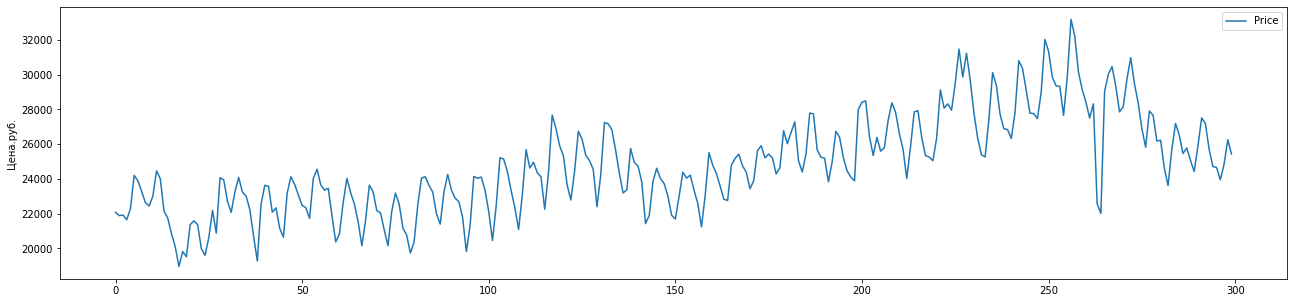

In [27]:
start = 100
length = 300
plt.figure(figsize=(22,5))
plt.plot(data[start:start+length], label="Price")
plt.ylabel('Цена.руб.')
plt.legend()
plt.show()


# Функция загрузки данных

In [55]:
#Формируем параметры загрузки данных

xLen = 60                      
valLen = 300                

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler(feature_range=(0, 1))
xTrain = xScaler.fit_transform(xTrain)
xTest = xScaler.fit_transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain, yTest = np.reshape(data[:trainLen], (-1 ,1)), np.reshape(data[trainLen+xLen+2:], (-1, 1)) 
yScaler = MinMaxScaler(feature_range=(0, 1))
yTrain = yScaler.fit_transform(yTrain)
yTest = yScaler.fit_transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

# LSTM

In [56]:
modelL = Sequential()
modelL.add(LSTM(units=50, return_sequences=True, input_shape=(xLen, 1)))
modelL.add(LSTM(units=50))
modelL.add(Dropout(0.2))
modelL.add(Dense(units=1))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

modelL.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = modelL.fit(trainDataGen, 
                    epochs=150, 
                    validation_data=testDataGen)

Epoch 1/150
37/37 [==============================] - 2s 60ms/step - loss: 0.0802 - val_loss: 0.0969
Epoch 2/150
37/37 [==============================] - 2s 57ms/step - loss: 0.0788 - val_loss: 0.0957
Epoch 3/150
37/37 [==============================] - 2s 58ms/step - loss: 0.0790 - val_loss: 0.0944
Epoch 4/150
37/37 [==============================] - 2s 57ms/step - loss: 0.0760 - val_loss: 0.0933
Epoch 5/150
37/37 [==============================] - 2s 57ms/step - loss: 0.0771 - val_loss: 0.0921
Epoch 6/150
37/37 [==============================] - 2s 56ms/step - loss: 0.0748 - val_loss: 0.0908
Epoch 7/150
37/37 [==============================] - 2s 57ms/step - loss: 0.0749 - val_loss: 0.0897
Epoch 8/150
37/37 [==============================] - 2s 57ms/step - loss: 0.0734 - val_loss: 0.0885
Epoch 9/150
37/37 [==============================] - 2s 57ms/step - loss: 0.0705 - val_loss: 0.0874
Epoch 10/150
37/37 [==============================] - 2s 57ms/step - loss: 0.0698 - val_loss: 0.0861

In [70]:
modelL.compile(loss="mse", optimizer=Adam(lr=1e-6))
history = modelL.fit(trainDataGen, 
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/20
37/37 [==============================] - 6s 77ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 2/20
37/37 [==============================] - 2s 55ms/step - loss: 0.0132 - val_loss: 0.0120
Epoch 3/20
37/37 [==============================] - 2s 55ms/step - loss: 0.0139 - val_loss: 0.0121
Epoch 4/20
37/37 [==============================] - 2s 54ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 5/20
37/37 [==============================] - 2s 55ms/step - loss: 0.0133 - val_loss: 0.0120
Epoch 6/20
37/37 [==============================] - 2s 55ms/step - loss: 0.0131 - val_loss: 0.0120
Epoch 7/20
37/37 [==============================] - 2s 56ms/step - loss: 0.0134 - val_loss: 0.0119
Epoch 8/20
37/37 [==============================] - 2s 58ms/step - loss: 0.0140 - val_loss: 0.0119
Epoch 9/20
37/37 [==============================] - 2s 57ms/step - loss: 0.0137 - val_loss: 0.0118
Epoch 10/20
37/37 [==============================] - 2s 55ms/step - loss: 0.0131 - val_loss: 0.0118
Epoch 11/

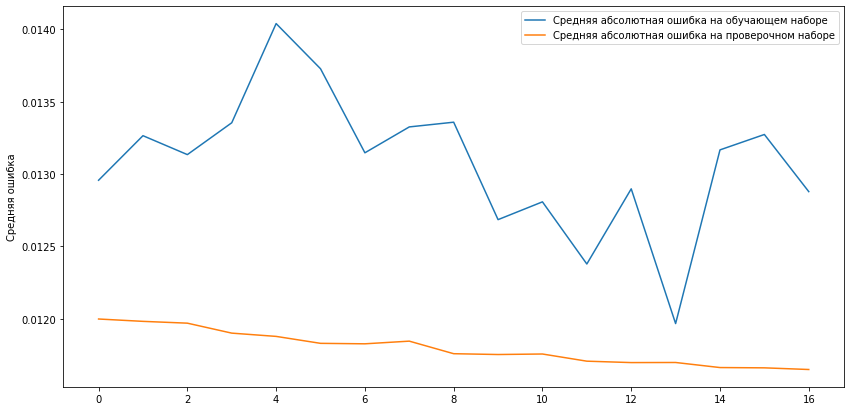

In [71]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][3:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][3:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [72]:
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [73]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=200, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [74]:
#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(modelL, xVal[0], yVal[0], yScaler)

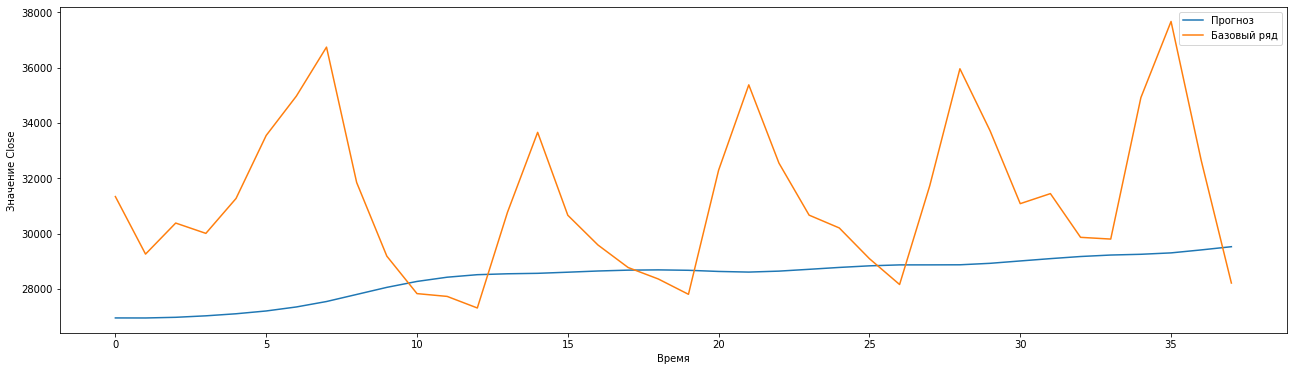

In [75]:
#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

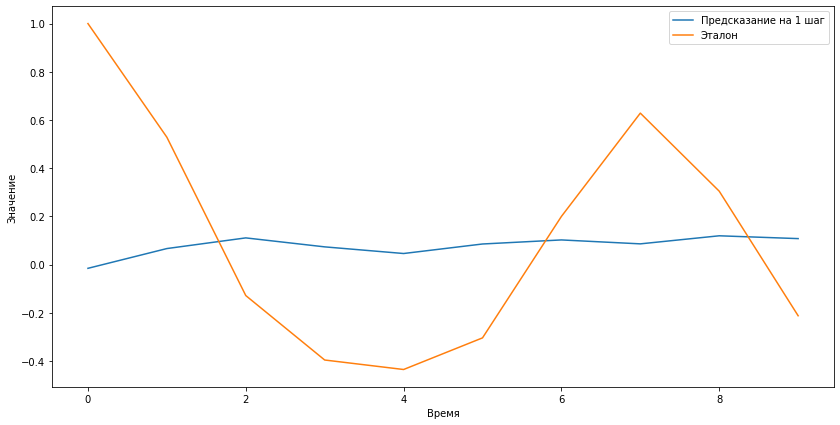

In [76]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

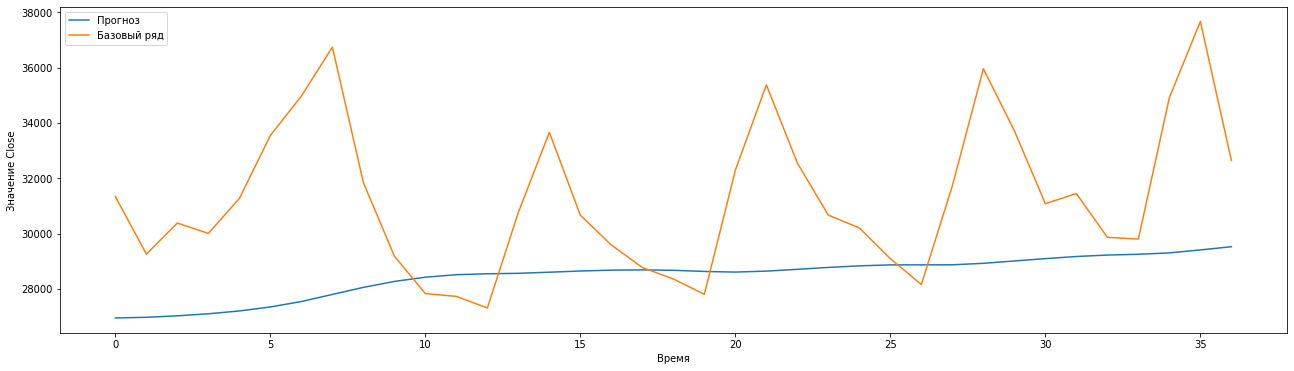

In [77]:
#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(modelL, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])